# Read Dataset


## Factor DF

In [1]:
import pandas as pd

df = pd.read_csv("feature_data/data.csv")

df = df.drop(columns=['Unnamed: 0'])

df


,date,ticker,pe_exi,de_ratio,close_price,exp_ret,vol,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,ret_excess
0,2016-02-29,AAP,23.193750,2.305863,131.959274,-0.000684,0.077602,-0.042258,-0.07,0.88,-0.57,3.25,2.02,0.0002,-0.000884
1,2016-03-31,AAP,25.053125,2.305863,142.591949,-0.000529,0.077550,-0.040434,6.96,1.07,1.19,0.77,-0.08,0.0002,-0.000729
2,2016-04-30,AAP,24.390625,2.305863,138.821274,0.008972,0.080094,0.072751,0.91,1.23,3.28,-2.97,1.90,0.0001,0.008872
3,2016-05-31,AAP,23.522936,2.362231,136.811432,0.010492,0.079151,0.093242,1.78,-0.61,-1.66,-1.09,-2.49,0.0001,0.010392
4,2016-06-30,AAP,24.714067,2.362231,143.795746,0.003330,0.076990,0.005550,-0.05,0.45,-1.48,1.41,1.94,0.0002,0.003130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13244,2024-08-31,XOM,14.107656,0.771855,114.883614,0.012588,0.052356,0.144777,1.61,-3.65,-1.13,0.85,0.86,0.0048,0.007788
13245,2024-09-30,XOM,14.021531,0.771855,114.182266,0.009021,0.051371,0.097898,1.74,-1.02,-2.59,0.04,-0.26,0.0040,0.005021
13246,2024-10-31,XOM,13.968900,0.771855,113.753670,0.003723,0.049151,0.031893,-0.97,-0.88,0.89,-1.38,1.03,0.0039,-0.000177
13247,2024-11-30,XOM,14.689913,0.737662,115.847267,0.011724,0.037114,0.141942,6.51,4.78,-0.05,-2.62,-2.17,0.0040,0.007724


In [2]:
# split the data into train and test sets
#train_df = df[df['date'] < '2024-01-01']
#test_df = df[df['date'] >= '2024-01-01']

#train_df = df

# Estimate returns & Covariances

In [3]:
from typing import Dict, List, Tuple
import numpy as np
import mgarch
factor_cols = ["Mkt-RF", "SMB", "HML", "RMW", "CMA"]


# ----- helper #1 :   β̂  and  F̂  --------------------------------
def fit_beta(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        # 1) strip rows that contain any non-finite value
    row_mask = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
    Xc, Yc   = X[row_mask], Y[row_mask]

    beta, *_ = np.linalg.lstsq(Xc, Yc, rcond=None)               # (d_x, d_y)
    resid    = Yc - Xc @ beta                                    # (n, d_y)
    F_hat    = np.diag(resid.var(axis=0, ddof=1))              # (d_y, d_y)
    return beta, F_hat


# ----- helper #2 :   one-step mean & cov ------------------------
def forecast_one_step(x_i, W_i, beta, F_hat):
    y_hat = x_i @ beta                                         # (d_y,)
    V_hat = beta.T @ W_i @ beta + F_hat                        # (d_y, d_y)
    return y_hat, V_hat

# ---- helper #3 : DCC-GARCH forecast of factor covariance ------
def dcc_garch_cov(X, ndays=1):
    dist = 't'
    vol = mgarch.mgarch(dist)
    vol.fit(X)
    W_t = vol.predict(ndays)['cov']
    return W_t

In [4]:
df['label'] = df.groupby('ticker')['close_price'].shift(-1).gt(df['close_price']).astype(int) * 2 - 1

In [5]:
df['ret'] = df.groupby('ticker')['close_price'].pct_change().shift(-1).fillna(0)

In [6]:
df['ret_excess'] = df['ret']

In [7]:
# get the how many 1s and 0s in the label column
label_counts = df['label'].value_counts()
print("Label counts:")
print(label_counts)

Label counts:
label
 1    7321
-1    5928
Name: count, dtype: int64


In [8]:
df

,date,ticker,pe_exi,de_ratio,close_price,exp_ret,vol,mom,Mkt-RF,SMB,HML,RMW,CMA,RF,ret_excess,label,ret
0,2016-02-29,AAP,23.193750,2.305863,131.959274,-0.000684,0.077602,-0.042258,-0.07,0.88,-0.57,3.25,2.02,0.0002,0.080575,1,0.080575
1,2016-03-31,AAP,25.053125,2.305863,142.591949,-0.000529,0.077550,-0.040434,6.96,1.07,1.19,0.77,-0.08,0.0002,-0.026444,-1,-0.026444
2,2016-04-30,AAP,24.390625,2.305863,138.821274,0.008972,0.080094,0.072751,0.91,1.23,3.28,-2.97,1.90,0.0001,-0.014478,-1,-0.014478
3,2016-05-31,AAP,23.522936,2.362231,136.811432,0.010492,0.079151,0.093242,1.78,-0.61,-1.66,-1.09,-2.49,0.0001,0.051051,1,0.051051
4,2016-06-30,AAP,24.714067,2.362231,143.795746,0.003330,0.076990,0.005550,-0.05,0.45,-1.48,1.41,1.94,0.0002,0.050918,1,0.050918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13244,2024-08-31,XOM,14.107656,0.771855,114.883614,0.012588,0.052356,0.144777,1.61,-3.65,-1.13,0.85,0.86,0.0048,-0.006105,-1,-0.006105
13245,2024-09-30,XOM,14.021531,0.771855,114.182266,0.009021,0.051371,0.097898,1.74,-1.02,-2.59,0.04,-0.26,0.0040,-0.003754,-1,-0.003754
13246,2024-10-31,XOM,13.968900,0.771855,113.753670,0.003723,0.049151,0.031893,-0.97,-0.88,0.89,-1.38,1.03,0.0039,0.018405,1,0.018405
13247,2024-11-30,XOM,14.689913,0.737662,115.847267,0.011724,0.037114,0.141942,6.51,4.78,-0.05,-2.62,-2.17,0.0040,-0.103425,-1,-0.103425


In [9]:
# -------------------------------------------------------------
# 1.  Build monthly factor (X_df) and asset-return (Y_df) tables

Y_df = (df
        .pivot(index='date', columns='ticker', values='ret_excess') # ret_excess can be used or ret
        .sort_index())

X_df = (df[['date'] + factor_cols]
        .drop_duplicates('date')
        .set_index('date')
        .sort_index())
# create a label_df
label_df = (df
            .pivot(index='date', columns='ticker', values='label')
            .sort_index())

# ------------------------------------------------------------------
# 1.  Find ticker columns with *any* NaNs in Y_df
# ------------------------------------------------------------------
bad_tickers = Y_df.columns[Y_df.isna().any()]

print(f"🗑  Dropping {len(bad_tickers)} tickers with missing returns:")
print(", ".join(map(str, bad_tickers)))

# ------------------------------------------------------------------
# 2.  Drop them from Y_df  (axis=1 ⇒ columns)
# ------------------------------------------------------------------
Y_df = Y_df.drop(columns=bad_tickers)

# ------------------------------------------------------------------
# 3.  OPTIONAL: keep your other pivot tables in sync
#     (uncomment if you have X_df, label_df, etc. with same columns)
# ------------------------------------------------------------------
# X_df      = X_df.drop(columns=bad_tickers, errors="ignore")
label_df  = label_df.drop(columns=bad_tickers, errors="ignore")
# Sigma_fore = Sigma_fore[np.ix_(good_mask, good_mask)]  # inside loop

# ------------------------------------------------------------------
# 4.  Verify — there should be zero NaNs left
# ------------------------------------------------------------------
assert not Y_df.isna().any().any(), "Still NaNs lurking in Y_df!"
print("✅  Y_df is now NaN-free and has", Y_df.shape[1], "tickers.")


🗑  Dropping 43 tickers with missing returns:
ABM, ACA, ACT, ADEA, ADMA, AESI, AHCO, ALRM, AMN, AMPH, AMR, ANGI, AORT, ARLO, AROC, ASIX, ASO, ATGE, AUB, AX, BAC, BH, BL, BTU, CABO, CALM, CARG, CARS, CC, CHEF, CLB, CNR, CRC, CRGY, CRK, CWEN, ENR, EPC, ESI, HCC, IAC, LUMN, MSGS
✅  Y_df is now NaN-free and has 98 tickers.


In [10]:
# 1) make sure every index really *is* a DatetimeIndex
X_df.index      = pd.to_datetime(X_df.index)
Y_df.index      = pd.to_datetime(Y_df.index)
label_df.index  = pd.to_datetime(label_df.index)
df['date'] = pd.to_datetime(df['date'])

In [11]:
# Every row is month-end already ⇒ just iterate over the index
month_ends = X_df.index.sort_values()

lookback = 12          # e.g. use the past 12 months
month_ends = month_ends[lookback:]

In [12]:
month_ends

DatetimeIndex(['2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
               '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
               '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
               '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
               '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31', '2020-08-31', '2020-09-30',
               '2020-10-31', '2020-11-30', '2020-12-31', '2021-01-31',
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
      

In [13]:
results = []
tickers = Y_df.columns.unique()
for me_date in month_ends:

    # ---------- 1) pick the estimation window ------------
    win_mask  = (X_df.index <= me_date)                     & \
                (X_df.index >  me_date - pd.offsets.MonthEnd(lookback))

    X_window  = X_df.loc[win_mask]
    Y_window  = Y_df.loc[win_mask]

    if len(X_window) < 2:
        continue   # still not enough data – skip

    # ---------- 2)  β̂ , F̂  from the window --------------
    beta_hat, F_hat = fit_beta(X_window.values, Y_window.values)

    # ---------- 3)  Σ̂ (covariance)  ----------------------
    # If you still want DCC-GARCH you can feed monthly returns straight in,
    # but most people just use a sample/Exp-Wtd cov here:
    W_hat = np.cov(X_window.values.T, ddof=1)
    #W_hat = dcc_garch_cov(X_window.values)
    
    x_today      = X_df.loc[me_date].values
    mu_fore, Sigma_fore = forecast_one_step(x_today, W_hat, beta_hat, F_hat)
    #  └─ make sure your forecast function is set up for “+1 month”,
    #     not “+1 trading day”.

    W = 12
    R_hist = (Y_df.loc[Y_df.index <= me_date]
                .tail(W)         # 12 rows = 12 months
                .T.values)       # (n_assets × W)
               
    # 5) features ----------------------------------------
    feature_list = ['exp_ret', 'vol','mom', 'pe_exi', 'de_ratio', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

    monthly = (df
               .set_index(['date','ticker'])
               .loc[me_date]
               .reindex(tickers))
    X_feat = monthly[feature_list].values

    # 6) labels ------------------------------------------
    y_vec = label_df.loc[me_date, tickers].values

    # 7) store snapshot ----------------------------------
    results.append(dict(date         = me_date,
                        X_feat       = X_feat,
                        returns_hist = R_hist,
                        y            = y_vec.astype(np.double),
                        mu_fore      = mu_fore.astype(np.double),
                        Sigma_fore   = Sigma_fore.astype(np.double),
                        beta         = beta_hat,
                        F_hat        = F_hat,
                        W_hat        = W_hat))

In [14]:
import numpy as np

# --- helper --------------------------------------------------------
def is_spd(mat: np.ndarray, tol: float = 1e-8) -> bool:
    """
    Return True if `mat` is symmetric-positive-definite.
    • First check symmetry (fast) – avoids false negatives from tiny asymmetry
    • Then try a Cholesky factorisation.  If it succeeds, SPD.
    • `tol` lets you ignore round-off noise on symmetry test.
    """
    if not np.allclose(mat, mat.T, atol=tol, rtol=0):
        return False
    try:
        np.linalg.cholesky(mat)
        return True
    except np.linalg.LinAlgError:
        return False

# --- scan the results list ----------------------------------------
bad = []                 # collect (index, date) for matrices that fail
for i, snap in enumerate(results):
    if not is_spd(snap["Sigma_fore"]):
        bad.append((i, snap["date"]))

# --- quick report --------------------------------------------------
total = len(results)
print(f"Σ̂ SPD check: {total - len(bad)}/{total} pass, {len(bad)} fail")

if bad:
    print("First few failures:")
    for idx, d in bad[:10]:
        print(f"  #{idx:3d}  {d}")


Σ̂ SPD check: 95/95 pass, 0 fail


In [15]:
import torch
import torch.nn as nn
from qpth.qp import QPFunction
torch.manual_seed(99)

def _check(tag, T):
    if torch.isnan(T).any() or torch.isinf(T).any():
        bad = torch.logical_or(torch.isnan(T), torch.isinf(T))
        idx = torch.nonzero(bad, as_tuple=True)
        print(f"[{tag}] bad @ indices:", idx, "values:", T[idx][:5])
        raise ValueError(f"{tag} contains NaN/Inf")
    
def sanitise_spd(M: torch.Tensor,
                 name: str = "Q",
                 eps: float = 1e-6) -> torch.Tensor:
    """
    1. reports NaN/Inf, duplicate rows, condition number, min/max eigenvalues
    2. drops exact duplicate rows/cols (they kill Cholesky)
    3. adds minimal jitter to make SPD
    """
    def _report(tag, val):  # compact helper
        print(f"[{name}] {tag}: {val}")

    # 0) NaN / Inf check -------------------------------------------------
    if torch.isnan(M).any() or torch.isinf(M).any():
        raise ValueError(f"[{name}] contains NaN or Inf – cannot factorise")

    # 1) deduplicate rows/cols ------------------------------------------
    #    (X rows that are numerically identical give zero-variance directions)
    # NOTE: this assumes you constructed M as  y yᵀ ⊙ X Xᵀ
    #       If that is not the case just delete the dedup block.
    with torch.no_grad():
        diag = torch.diag(M)
        mask_nonzero = diag > 0      # rows with all-zero features have 0 on diag
        if mask_nonzero.sum() < len(mask_nonzero):
            _report("duplicate/zero rows removed",
                    int(len(mask_nonzero) - mask_nonzero.sum()))
            M = M[mask_nonzero][:, mask_nonzero]

    # 2) minimal jitter --------------------------------------------------
    eigvals = torch.linalg.eigvalsh(M)
    λmin    = eigvals.min().item()
    λmax    = eigvals.max().item()
    cond    = λmax / max(λmin, eps)
    #_report("λ_min",  λmin)
    #_report("λ_max",  λmax)
    #_report("cond",   cond)

    jitter  = max(eps, -λmin + eps)
    M       = M + jitter * torch.eye(M.size(0), device=M.device, dtype=M.dtype)

    # final safety: Cholesky must succeed now
    try:
        torch.linalg.cholesky(M)
    except RuntimeError as e:
        raise RuntimeError(f"[{name}] still not SPD even after jitter = {jitter}") from e

    return M


class EndToEndSVM_MVO_Sigmoid(nn.Module):
    def __init__(self,
                 in_features: int,
                 C_svm: float,
                 eps: float,
                 tau: float
            ):
        """
        in_features : number of raw features per asset
        C_svm       : SVM dual box-constraint
        eps         : jitter to ensure all Q-matrices are SPD
        tau         : sigmoid temperature for soft gating
        """
        super().__init__()
        # 1)  make the learnable projection W (d × d, no bias)
        self.embed = nn.Linear(in_features, in_features, bias=False).double()

        # 2)  start it as an identity matrix instead of tiny random numbers
        nn.init.eye_(self.embed.weight)          # ← this line

        self.C   = C_svm
        self.eps = eps
        self.tau = tau

    def forward(self,
                X_feat: torch.Tensor,     # (n,d)
                y: torch.Tensor,          # ±1
                mu_est: torch.Tensor,     # (n,)  
                Sigma_est: torch.Tensor,  # (n,n) 
                return_goal: float
               ) -> torch.Tensor:
        n, d = X_feat.shape
        # A. raw input
        #_check("X_feat", X_feat)


        # 1) feature embedding
        Xp = self.embed(X_feat.double())
        #_check("Xp", Xp)
        y  = y.view(-1).double()           # now y is float64 ±1

        # 2) SVM dual QP
        K      = Xp @ Xp.t()                             # (n, n)
        #_check("K", K)

        yy    = y.unsqueeze(1) * y.unsqueeze(0)  # (n,n) float64
        Q_svm  = sanitise_spd((y[:,None] * y[None,:]) * K, name="Q_svm", eps=self.eps)
        #_check("Q_svm", Q_svm)
        p_svm  = -torch.ones(n, device=Xp.device, dtype=Xp.dtype)

        G_svm  = torch.cat([
            -torch.eye(n, device=Xp.device, dtype=Xp.dtype),
             torch.eye(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n, n)
        h_svm  = torch.cat([
            torch.zeros(n, device=Xp.device, dtype=Xp.dtype),
            self.C * torch.ones(n, device=Xp.device, dtype=Xp.dtype)
        ], dim=0)                                        # (2n,)

        A_svm  = y.view(1,-1)#.to(Xp)                     # (1, n)
        b_svm  = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)
        # ---------------------------------------------------------------
        # handle single-class case (all +1  *or*  all –1)
        # ---------------------------------------------------------------
        if (y == y[0]).all():              # every label identical
            A_svm = torch.empty(0, n, device=Xp.device, dtype=Xp.dtype)  # shape (0, n)
            b_svm = torch.empty(0,       device=Xp.device, dtype=Xp.dtype)  # shape (0,)
            print("Warning: all labels identical, no SVM hyperplane constructed.")
        else:
            A_svm = y.view(1, -1)                                           # (1, n)
            b_svm = torch.zeros(1, device=Xp.device, dtype=Xp.dtype)        # (1,)

        alpha      = QPFunction(verbose=False)(
                    Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm
                 )                                  # (n,)
        alpha      = torch.clamp(alpha, 0.0, self.C)

        # 3) build hyperplane and score
        # after solving for alpha
        # construct w_svm properly:
        # make sure alphas is a 1-D tensor of length 
        alpha = alpha.view(-1)               

        # ensure y is double or double to match alphas dtype
        y = y.to(alpha.dtype)            

        # elementwise product alpha_i * y_i
        alpha_y = alpha * y                
        w_svm = Xp.t().mv(alpha_y)                   # or torch.matmul(X.t(), alpha_y)

        scores = Xp @ w_svm                 # (n_assets,)

        # diagnostic
        with torch.no_grad():
            print("‖w_svm‖₂       :", w_svm.norm().item())
            print("‖alpha‖₁       :", alpha.abs().sum().item())
            print("scores min/max :", scores.min().item(), scores.max().item())
            
        hinge = torch.clamp(1.0 - y * scores, min=0.0).mean()



        # 4) differentiable sigmoid gate
        mask   = torch.sigmoid(scores / self.tau)        # (n,) in (0,1)
        print("Mask mean value: ", mask.mean())




        # 5) MVO QP *over all assets* with w_i ≤ mask_i
        #    compute moments for every asset
        # ---------- 2) MVO QP using *forecast* μ, Σ ----------
        mu     = mu_est                             # (n,)
        Sigma  = Sigma_est
        
        with torch.no_grad():
            # upper-bound portfolio return with current mask
            r_max = (mu * mask).sum()          # all weight mass on highest μ allowed
            print(f"max feasible return = {r_max.item():.4f}  |  goal = {return_goal}")

            if r_max < return_goal - 1e-8:
                print("⚠️  Target return is infeasible for this mask snapshot.")

        P_mvo  = Sigma
        q_mvo  = torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype)

        # box constraints: 0 ≤ w ≤ mask
        G_box  = torch.cat([
            -torch.eye(n, device=Sigma.device, dtype=Sigma.dtype),  # -w ≤ 0
             torch.eye(n, device=Sigma.device, dtype=Sigma.dtype)   #  w ≤ mask
        ], dim=0)                                                   # (2n, n)
        h_box  = torch.cat([
            torch.zeros(n, device=Sigma.device, dtype=Sigma.dtype),
            mask
        ], dim=0)                                                   # (2n,)

        # ------------------ NEW inequality: μᵀw ≥ return_goal -------------
        G_ret = -mu.unsqueeze(0)                                     # (1, n)
        h_ret = -torch.tensor([return_goal],
                            device=Sigma.device, dtype=Sigma.dtype)

        # concat all inequalities
        G_ineq = torch.cat([G_box, G_ret], dim=0)                    # (2n+1, n)
        h_ineq = torch.cat([h_box, h_ret], dim=0)                    # (2n+1,)

        # equality: sum(w)=1
        A_eq = torch.ones(1, n, device=Sigma.device, dtype=Sigma.dtype)  # (1, n)                                             
        b_eq = torch.tensor([1.0], device=Sigma.device, dtype=Sigma.dtype)

        w_opt  = QPFunction(verbose=False)(
                    P_mvo, q_mvo, G_ineq, h_ineq, A_eq, b_eq
                 )                                  # (n,)
        # 2. Check return target vs feasible region
        #print("mask_min/max:", mask.min().item(), mask.max().item())
        #print("mu_min/max:",   mu.min().item(),   mu.max().item(), "goal:", return_goal)
        
        return w_opt.view(-1), hinge             # (n,)

In [16]:
from torch.utils.data import Dataset, DataLoader
snapshots = sorted(results, key=lambda s: s["date"])   # ensure sorted

val_fraction = 0.2
n_total      = len(snapshots)
n_val        = int(n_total * val_fraction)

train_snaps  = snapshots[:-n_val]          # earlier dates
val_snaps    = snapshots[-n_val:]          # most recent dates

# ---------- 1.  tiny helper --------------------------------------------------
def to_tensor(x, *, dtype=torch.float64):
    """
    NumPy → torch, replace NaN/Inf with finite numbers
    (you can swap 'nan=0.0' for any imputation of your choice).
    """
    x = np.nan_to_num(x, nan=0.0, posinf=1e6, neginf=-1e6)
    return torch.as_tensor(x, dtype=dtype)


# ---------- 2.  custom Dataset ----------------------------------------------
class SnapshotDataset(Dataset):
    """
    Each item is one time-snapshot:
        X_feat, y, mu_fore, Sigma_fore, return_goal
    Shapes:
        X_feat      (n, d)   – features
        y           (n,)     – ±1 labels
        mu_fore     (n,)
        Sigma_fore  (n, n)
    """
    def __init__(self, results, return_goal):
        self.data = []

        for snap in results:
            X  = to_tensor(snap["X_feat"])      # (n, d)
            y  = to_tensor(snap["y"]).view(-1)  # (n,)
            mu = to_tensor(snap["mu_fore"])     # (n,)
            S  = to_tensor(snap["Sigma_fore"])  # (n, n)

            # ---------- basic sanity: drop rows that are still all-zero ------
            # (happens if the original had only NaNs)
            keep = (X.abs().sum(dim=1) > 0)
            if keep.sum() < 2:                  # need ≥2 points for an SVM
                continue                         # skip this snapshot

            X, y, mu = X[keep], y[keep], mu[keep]
            S        = S[keep][:, keep]

            self.data.append((X, y, mu, S, float(return_goal)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]          # batch = tuple of 5 tensors

In [144]:
#######################################################################
# 0. imports & helper  ###############################################
#######################################################################
import copy, torch, math
from qpth.qp import QPFunction

# ---------------------------------------------------------------------
# EXTRA ➋   classify assets by SVM sign -------------------------------
# ---------------------------------------------------------------------
def classify_assets(model, X, y, C, names=None):
    """returns two Python lists: invest, not_invest"""
    alpha, w_svm, _ = solve_svm(model, X, y, C)
    scores = model.embed(X.double()) @ w_svm            # (n,)
    invest = (scores > 0).nonzero(as_tuple=True)[0]     # long side
    avoid  = (scores <= 0).nonzero(as_tuple=True)[0]    # short / 0
    if names is not None:
        invest = [names[i] for i in invest.cpu().numpy()]
        avoid  = [names[i] for i in avoid.cpu().numpy()]
    else:
        invest = invest.cpu().tolist()
        avoid  = avoid.cpu().tolist()
    return invest, avoid

def make_spd(M, eps=1e-6):
    """Add minimal diagonal jitter until Cholesky succeeds."""
    I = torch.eye(M.size(0), device=M.device, dtype=M.dtype)
    jitter = eps
    for _ in range(10):
        try:
            torch.linalg.cholesky(M)
            return M
        except RuntimeError:
            M = (M + M.t()) * 0.5 + jitter * I
            jitter *= 10
    raise RuntimeError("Unable to make SPD matrix")

def solve_svm(model, X_feat, y, C):
    """
    Runs *just* the SVM part of EndToEndSVM_MVO_Sigmoid and
    returns (alpha, w_svm, support_index_tensor)
    """
    Xp = model.embed(X_feat.double())            # (n,d)
    y  = y.view(-1).double()                     # (n,)

    K      = Xp @ Xp.t()
    Q_svm  = (y[:,None] * y[None,:]) * K
    Q_svm  = make_spd(Q_svm)

    n      = Xp.size(0)
    p_svm  = -torch.ones(n, dtype=Xp.dtype, device=Xp.device)
    G_svm  = torch.cat([-torch.eye(n, dtype=Xp.dtype, device=Xp.device),
                         torch.eye(n, dtype=Xp.dtype,  device=Xp.device)], 0)
    h_svm  = torch.cat([torch.zeros(n, dtype=Xp.dtype, device=Xp.device),
                        C*torch.ones(n, dtype=Xp.dtype, device=Xp.device)], 0)

    if (y == y[0]).all():              # single-class edge case
        A_svm = torch.empty(0, n, dtype=Xp.dtype, device=Xp.device)
        b_svm = torch.empty(0,    dtype=Xp.dtype, device=Xp.device)
    else:
        A_svm = y.unsqueeze(0)
        b_svm = torch.zeros(1, dtype=Xp.dtype, device=Xp.device)

    alpha = QPFunction(verbose=False)(Q_svm, p_svm, G_svm, h_svm, A_svm, b_svm)
    alpha = torch.clamp(alpha, 0, C).view(-1)

    w_svm = Xp.t().mv(alpha * y)       # weight vector in embedded space
    sv    = (alpha > 1e-6)             # boolean mask of support vectors
    #sv = (alpha > 1e-6)
    return alpha, w_svm, sv.nonzero(as_tuple=True)[0]

C_svm = 0.01
tau = 0.05
#######################################################################
# 1. create model & *save* the initial weights  #######################
#######################################################################
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model    = EndToEndSVM_MVO_Sigmoid(in_features=10, C_svm=C_svm,
                                   eps=1e-6, tau=tau).to(device)

model_init = copy.deepcopy(model).to(device)   # frozen copy for later


#######################################################################
# 2. … your usual training loop here …
#######################################################################
# (use early-stopping or fixed epochs – whatever you prefer)
# after training 'model' contains the *trained* embed weights
# --------------------------------------------------------------------
return_goals = [0.09]       # test values

train_set = SnapshotDataset(train_snaps, return_goal=return_goals[0])
val_set   = SnapshotDataset(val_snaps,   return_goal=return_goals[0])

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=1, shuffle=False)

n_features = results[0]["X_feat"].shape[1]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = EndToEndSVM_MVO_Sigmoid(
            in_features=n_features,
            C_svm=C_svm,
            eps=1e-6,
            tau=tau).to(device)

optim  = torch.optim.Adam(model.parameters(), lr=1e-3)

patience   = 10         # stop if no progress for 10 epochs
min_delta  = 1e-6      # what counts as “progress”
#min_delta  = 1e-7      # what counts as “progress”
max_epochs = 150      # hard cap (safety)
best_val   = math.inf
wait       = 0
loss_hist, val_hist = [], []
λ_hinge    = 0.0

for epoch in range(1, max_epochs+1):
    # ---- TRAIN --------------------------------------------------------
    print("-----------------------------------------Epoch: ", epoch, "----------------------------------------")
    model.train()
    train_loss, n_batches = 0.0, 0
    for X, y, mu, Sigma, goal in train_loader:
        if torch.unique(y).numel() < 2:        # ← all +1 or all –1
            continue                           # skip this batch entirely
        X, y, mu, Sigma = (t.squeeze(0).to(device) for t in (X, y, mu, Sigma))

        w, hinge     = model(X, y, mu, Sigma, goal)
        
        var_loss = torch.dot(w, Sigma @ w)
        loss  = var_loss + λ_hinge * hinge

        optim.zero_grad()
        loss.backward()
        # put this inside the training loop, **after** loss.backward()
        gnorm = model.embed.weight.grad.norm()
        print(f"grad‖embed‖ = {gnorm.item():.3e}")   # should not be 0
        optim.step()

        train_loss += loss.item();  n_batches += 1

    train_loss /= n_batches
    loss_hist.append(train_loss)

    # ---- VALIDATE -----------------------------------------------------
    model.eval();  val_loss, n_batches = 0.0, 0
    with torch.no_grad():
        for X, y, mu, Sigma, goal in val_loader:
            if torch.unique(y).numel() < 2:        # ← all +1 or all –1
                continue                           # skip this batch entirely
            X, y, mu, Sigma = (t.squeeze(0).to(device) for t in (X, y, mu, Sigma))
            w, hinge = model(X, y, mu, Sigma, goal)
            var_val_loss = torch.dot(w, Sigma @ w)
            loss = var_val_loss + λ_hinge * hinge
            val_loss += loss.item(); n_batches += 1
    val_loss /= n_batches
    val_hist.append(val_loss)

    print(f"epoch {epoch:3d} | train {train_loss:.6f} | val {val_loss:.6f}")

    # ---- EARLY-STOPPING LOGIC ----------------------------------------
    if val_loss < best_val - min_delta:
        best_val = val_loss
        wait     = 0
        torch.save(model.state_dict(), "best_model.pt")   # checkpoint
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stop: no val improvement in {patience} epochs")
            break


-----------------------------------------Epoch:  1 ----------------------------------------
‖w_svm‖₂       : 0.023789445054010108
‖alpha‖₁       : 0.8599999999999828
scores min/max : -0.051389728619721305 0.07023443335975885
Mask mean value:  tensor(0.4880, dtype=torch.float64, grad_fn=<MeanBackward0>)
max feasible return = 0.6506  |  goal = tensor([0.0900], dtype=torch.float64)
grad‖embed‖ = 2.316e-14
‖w_svm‖₂       : 0.11503395115845469
‖alpha‖₁       : 0.6485480408601536
scores min/max : -17.696820368066064 2.096458227684054
Mask mean value:  tensor(0.7404, dtype=torch.float64, grad_fn=<MeanBackward0>)
max feasible return = 0.1721  |  goal = tensor([0.0900], dtype=torch.float64)
grad‖embed‖ = 3.874e-09
‖w_svm‖₂       : 0.0048202231775053336
‖alpha‖₁       : 0.3799999999999992
scores min/max : -0.008563399142324919 0.0017885251170978126
Mask mean value:  tensor(0.4954, dtype=torch.float64, grad_fn=<MeanBackward0>)
max feasible return = -0.8826  |  goal = tensor([0.0900], dtype=torch.

In [155]:
# pick ONE snapshot to test on – e.g. the last in validation set
test_snap   = val_set[0]                # (X, y, mu, Sigma, goal)

X_t, y_t, *_ = test_snap
X_t, y_t     = X_t.to(device), y_t.to(device)

print("=== Comparing INITIAL vs TRAINED SVM support vectors ===")
print(f"snapshot date: {val_snaps[6]['date']}\n")

# -------- initial model ---------------------------------------------
alpha0, w0, sv0 = solve_svm(model_init, X_t, y_t, C_svm)
print(f"INIT  | #SV = {len(sv0):2d} | indices:", sv0.cpu().numpy())

# -------- trained model ---------------------------------------------
alpha1, w1, sv1 = solve_svm(model,       X_t, y_t, C_svm)
print(f"TRAIN | #SV = {len(sv1):2d} | indices:", sv1.cpu().numpy())


=== Comparing INITIAL vs TRAINED SVM support vectors ===
snapshot date: 2023-12-31 00:00:00

INIT  | #SV = 59 | indices: [ 4  5  7  8  9 10 12 13 14 16 17 18 19 20 23 25 26 27 28 29 33 34 35 37
 38 39 41 43 46 48 50 53 55 56 58 59 62 63 65 66 69 70 72 74 75 76 77 78
 79 80 81 83 84 87 90 91 94 95 97]
TRAIN | #SV = 59 | indices: [ 4  5  7  8  9 10 12 13 14 16 17 18 19 20 23 25 26 27 28 29 33 34 35 37
 38 39 41 43 46 48 50 53 55 56 58 59 62 63 65 66 69 70 72 74 75 76 77 78
 79 80 81 83 84 87 90 91 94 95 97]


In [146]:
init_sv_tics  = [tickers[i] for i in sv0.cpu().numpy()]
train_sv_tics = [tickers[i] for i in sv1.cpu().numpy()]

print("INIT  | #SV =", len(init_sv_tics),  "|", init_sv_tics)
print("TRAIN | #SV =", len(train_sv_tics), "|", train_sv_tics)

INIT  | #SV = 59 | ['ABG', 'ACAD', 'ACLS', 'ADUS', 'AEIS', 'AEO', 'AGYS', 'AIN', 'AIR', 'ALG', 'ALGT', 'AMD', 'AMSF', 'AMWD', 'ANIP', 'APD', 'APOG', 'ARWR', 'ATEN', 'AVA', 'BCPC', 'BGS', 'BHE', 'BKE', 'BLMN', 'BRK-B', 'CCOI', 'CENT', 'COP', 'CPK', 'CVX', 'DIS', 'ECL', 'EOG', 'FIZZ', 'FMC', 'GOGO', 'GOOG', 'HON', 'JNJ', 'LLY', 'LOW', 'MCD', 'META', 'MGEE', 'MRK', 'MSEX', 'MSFT', 'NEE', 'NFLX', 'NVDA', 'ORCL', 'OTTR', 'RTX', 'TMUS', 'TSLA', 'V', 'VMC', 'XOM']
TRAIN | #SV = 59 | ['ABG', 'ACAD', 'ACLS', 'ADUS', 'AEIS', 'AEO', 'AGYS', 'AIN', 'AIR', 'ALG', 'ALGT', 'AMD', 'AMSF', 'AMWD', 'ANIP', 'APD', 'APOG', 'ARWR', 'ATEN', 'AVA', 'BCPC', 'BGS', 'BHE', 'BKE', 'BLMN', 'BRK-B', 'CCOI', 'CENT', 'COP', 'CPK', 'CVX', 'DIS', 'ECL', 'EOG', 'FIZZ', 'FMC', 'GOGO', 'GOOG', 'HON', 'JNJ', 'LLY', 'LOW', 'MCD', 'META', 'MGEE', 'MRK', 'MSEX', 'MSFT', 'NEE', 'NFLX', 'NVDA', 'ORCL', 'OTTR', 'RTX', 'TMUS', 'TSLA', 'V', 'VMC', 'XOM']


In [147]:
import copy, torch, numpy as np


# 1) forward once, grab alphas and weight vector
alpha0, w0, sv0 = solve_svm(model_init, X_t, y_t, model.C)
alpha1, w1, sv1 = solve_svm(model,       X_t, y_t, model.C)

print("Δ‖embed‖₂ =", torch.norm(model.embed.weight - model_init.embed.weight))
print("#SV init =", len(sv0), " | #SV train =", len(sv1))
print("init SV indices :", sv0.cpu().numpy()[:15])
print("train SV indices:", sv1.cpu().numpy()[:15])

# cosine similarity between the two hyper-planes
cos = (w0 @ w1) / (w0.norm() * w1.norm())
print("cos( w₀ , w₁ ) =", cos.item())

Δ‖embed‖₂ = tensor(1.5102, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)
#SV init = 59  | #SV train = 59
init SV indices : [ 4  5  7  8  9 10 12 13 14 16 17 18 19 20 23]
train SV indices: [ 4  5  7  8  9 10 12 13 14 16 17 18 19 20 23]
cos( w₀ , w₁ ) = 0.9142729607175512


In [148]:
# convert tickers list to numpy array

tick_vec = np.array(tickers)

Xsnap = val_snaps[0]      
X_test = to_tensor(Xsnap["X_feat"]).to(device)
y_test = to_tensor(Xsnap["y"]).to(device)


for g in return_goals:
    print(f"\n================  return_goal = {g:.1e}  ================")

    inv0, avo0 = classify_assets(model_init,  X_test, y_test, model_init.C,  tick_vec)
    inv1, avo1 = classify_assets(model, X_test, y_test, model.C, tick_vec)

    # ---- pretty print ------------------------------------------------
    def _fmt(lst): return ", ".join(str(x) for x in lst) if lst else "—"

    print("Initial SVM")
    print("  invest :", _fmt(inv0))
    print("  avoid  :", _fmt(avo0))

    print("Trained SVM")
    print("  invest :", _fmt(inv1))
    print("  avoid  :", _fmt(avo1))

    # ---- simple diff -------------------------------------------------
    added   = sorted(set(inv1) - set(inv0))
    removed = sorted(set(inv0) - set(inv1))
    if added or removed:
        print("Δ support:")
        if added:   print("  ➕ moved to invest :", _fmt(added))
        if removed: print("  ➖ moved to avoid  :", _fmt(removed))
    else:
        print("No change in invest/avoid sets.")


================  return_goal = 9.0e-02  ================
Initial SVM
  invest : AAP, AAPL, ABBV, ABCB, ABG, ACAD, ACIW, ACLS, ADUS, AEIS, AEO, AEP, AGYS, AIN, AIR, AL, ALG, ALGT, AMD, AMSF, AMWD, AMZN, ANDE, ANIP, APAM, APD, APOG, ARWR, ATEN, AVA, AWR, AXL, BANC, BCPC, BGS, BHE, BJRI, BKE, BLMN, BRK-B, CAT, CE, CENT, CENX, CNK, COP, COST, CPK, CVI, CVX, CWT, D, DIS, DUK, ECL, EOG, FCX, FIZZ, FMC, FUL, GE, GOOG, HD, HON, JNJ, JPM, KO, LLY, MA, MDU, META, MGEE, MRK, MSEX, MSFT, NEE, NFLX, NVDA, NWN, OTTR, PEP, PG, RTX, SHW, SO, TMUS, TSLA, UNH, UNP, V, VMC, WMT, XOM
  avoid  : CCOI, GOGO, LOW, MCD, ORCL
Trained SVM
  invest : AAPL, ABBV, ABCB, AMZN, APAM, AXL, BANC, BLMN, CAT, CNK, CVI, GE, HD, JPM, LLY, MA, PEP, SHW, UNP
  avoid  : AAP, ABG, ACAD, ACIW, ACLS, ADUS, AEIS, AEO, AEP, AGYS, AIN, AIR, AL, ALG, ALGT, AMD, AMSF, AMWD, ANDE, ANIP, APD, APOG, ARWR, ATEN, AVA, AWR, BCPC, BGS, BHE, BJRI, BKE, BRK-B, CCOI, CE, CENT, CENX, COP, COST, CPK, CVX, CWT, D, DIS, DUK, ECL, EOG, FCX, FIZZ

C:\Users\ksg\AppData\Local\Temp\ipykernel_18580\2802520318.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


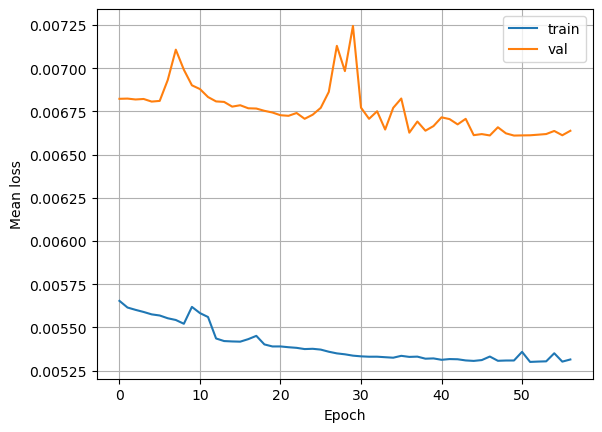

In [149]:
import matplotlib.pyplot as plt 

model.load_state_dict(torch.load("best_model.pt"))
plt.plot(loss_hist, label="train")
plt.plot(val_hist,  label="val")
plt.xlabel("Epoch"); plt.ylabel("Mean loss")
plt.legend(); plt.grid(True); plt.show()

In [150]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC                     # keeps support_ info
import numpy as np, torch

# ---------- gather pooled (X, y) ------------------------------------
X_rows, y_rows = [], []
for snap in train_snaps:
    X = snap["X_feat"]          # NumPy already (n,d)
    y = snap["y"]               # (n,)
    mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
    if mask.sum() >= 2:         # need ≥2 classes inside the batch
        X_rows.append(X[mask])
        y_rows.append(y[mask])

X_train = np.vstack(X_rows)
y_train = np.concatenate(y_rows)

# ---------- build & fit ---------------------------------------------
C_svm = 0.01
svm_clf = make_pipeline(
    StandardScaler(),                       # per-feature z-score
    SVC(kernel="linear", C=C_svm)
)
svm_clf.fit(X_train, y_train)

print("# training support vectors =", svm_clf[-1].support_.size)

def mvo_from_scores(scores, mu, Sigma, tau, goal):
    """
    Turn `scores` → mask → solve the identical QP used in your NN forward.

    scores, mu : 1-D torch tensors   (n,)
    Sigma      : 2-D torch tensor    (n,n)
    """
    mask = torch.sigmoid(scores / tau)           # gate
    n    = len(scores)

    # ----- inequalities ------------------------------------------------
    G_box = torch.cat([-torch.eye(n),  torch.eye(n)], 0)
    h_box = torch.cat([torch.zeros(n), mask], 0)

    G_ret = -mu.unsqueeze(0)
    h_ret = -torch.tensor([goal], dtype=mu.dtype)

    G = torch.cat([G_box, G_ret], 0)
    h = torch.cat([h_box, h_ret], 0)

    # ----- equality ----------------------------------------------------
    A = torch.ones(1, n, dtype=mu.dtype)
    b = torch.tensor([1.0], dtype=mu.dtype)

    w = QPFunction(verbose=False)(
            Sigma, torch.zeros(n, dtype=mu.dtype), G, h, A, b
        )
    return w, mask

nn_stats  = []          # (var, feasible?, mean mask)
svm_stats = []

model.eval()
with torch.no_grad():
    for snap in val_snaps:
        # ------------ tensors -----------------------------------------
        X  = torch.as_tensor(snap["X_feat"],  dtype=torch.float64)
        y  = torch.as_tensor(snap["y"],       dtype=torch.float64)
        mu = torch.as_tensor(snap["mu_fore"], dtype=torch.float64)
        S  = torch.as_tensor(snap["Sigma_fore"], dtype=torch.float64)
        goal = 0.09

        # ------------ neural network ----------------------------------
        w_nn, _ = model(X, y, mu, S, goal)
        var_nn  = (w_nn @ (S @ w_nn)).item()
        feas_nn = (mu @ w_nn >= goal - 1e-8).item()
        nn_stats.append((var_nn, feas_nn))

        # ------------ SVM pipeline ------------------------------------
        #  a) get standardised features identical to training pipe
        X_std   = torch.as_tensor(
                     svm_clf[:-1].transform(X.numpy()), dtype=torch.float64)
        #  b) linear scores:  X_std @ w + b
        coef    = torch.as_tensor(svm_clf[-1].coef_.ravel(),
                                  dtype=torch.float64)
        bias    = torch.as_tensor(svm_clf[-1].intercept_, dtype=torch.float64)
        scores  = X_std @ coef + bias

        w_svm, mask = mvo_from_scores(scores, mu, S, tau=0.1, goal=goal)
        var_svm = (w_svm @ S @ w_svm.T).item()
        feas_svm = (mu @ w_svm.T >= goal - 1e-8).item()
        svm_stats.append((var_svm, feas_svm))

# ------------- aggregate ----------------------------------------------
import pandas as pd
df = pd.DataFrame({
    "var_nn"  : [v for v,_ in nn_stats],
    "var_svm" : [v for v,_ in svm_stats],
    "feas_nn" : [f for _,f in nn_stats],
    "feas_svm": [f for _,f in svm_stats]
})
print(df.describe())
print("feasible ratio NN  :", df.feas_nn.mean())
print("feasible ratio SVM :", df.feas_svm.mean())


# training support vectors = 6545
‖w_svm‖₂       : 0.08517670901574435
‖alpha‖₁       : 0.5780456422152989
scores min/max : -2.1154033597001454 5.799849306884821
Mask mean value:  tensor(0.2819, dtype=torch.float64)
max feasible return = 0.1109  |  goal = 0.09

--------
qpth warning: Returning an inaccurate and potentially incorrect solution.

Some residual is large.
Your problem may be infeasible or difficult.

You can try using the CVXPY solver to see if your problem is feasible
and you can use the verbose option to check the convergence status of
our solver while increasing the number of iterations.

Advanced users:
You can also try to enable iterative refinement in the solver:
https://github.com/locuslab/qpth/issues/6
--------

‖w_svm‖₂       : 3.959191922020834e-07
‖alpha‖₁       : 0.5799999999999739
scores min/max : -3.320238276695594e-07 -2.4098393615283107e-07
Mask mean value:  tensor(0.5000, dtype=torch.float64)
max feasible return = -0.7446  |  goal = 0.09
⚠️  Target return i

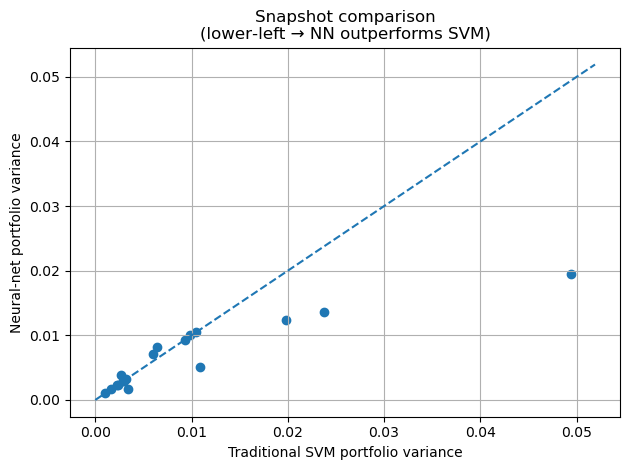

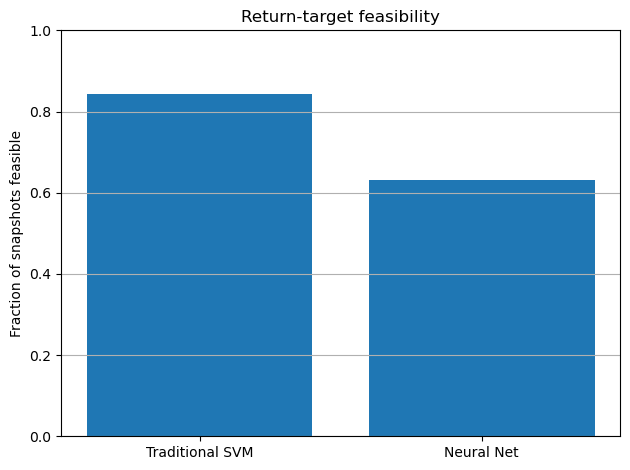

In [151]:
import matplotlib.pyplot as plt

# ----- ASSUMPTIONS ---------------------------------------------------
# 1) df is a pandas DataFrame already in memory
# 2) It has four columns named exactly:
#        'var_nn', 'var_svm', 'feas_nn', 'feas_svm'
#    where
#        • var_*     : portfolio variance (float)
#        • feas_*    : boolean or 0/1 feasible flag
# ---------------------------------------------------------------------

try:
    df  # noqa: F401
except NameError:
    raise RuntimeError("DataFrame 'df' with columns var_nn, var_svm, feas_nn, feas_svm was not found.")

# -------- Scatter: variance NN vs traditional SVM --------------------
plt.figure()
plt.scatter(df["var_svm"], df["var_nn"])
max_val = max(df["var_svm"].max(), df["var_nn"].max()) * 1.05
plt.plot([0, max_val], [0, max_val], linestyle='--')   # y = x reference
plt.xlabel("Traditional SVM portfolio variance")
plt.ylabel("Neural‑net portfolio variance")
plt.title("Snapshot comparison\n(lower‑left → NN outperforms SVM)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- Bar: feasibility ratio -------------------------------------
plt.figure()
feas_rates = [df["feas_svm"].mean(), df["feas_nn"].mean()]
labels     = ["Traditional SVM", "Neural Net"]
plt.bar(labels, feas_rates)
plt.ylabel("Fraction of snapshots feasible")
plt.title("Return‑target feasibility")
plt.ylim(0, 1)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [470]:
# ------------------------------------------------------------
# 0.  Collect one big (X, y) matrix from the training snapshots
# ------------------------------------------------------------
import numpy as np

X_rows, y_rows = [], []
for snap in train_snaps:          # ← the earlier-date part of `snapshots`
    X  = snap["X_feat"]           # (n_assets, d_features)  – NumPy already
    y  = snap["y"]                # (n_assets,)            – ±1 labels

    # keep only rows with finite numbers
    mask = np.isfinite(X).all(axis=1)
    if mask.sum() < 2:            # need at least 2 distinct labels
        continue
    X_rows.append(X[mask])
    y_rows.append(y[mask])

X_train = np.vstack(X_rows)       # shape (N_total_assets , d)
y_train = np.concatenate(y_rows)  # shape (N_total_assets ,)

print("training matrix:", X_train.shape)

# ------------------------------------------------------------
# 1.  Build a pipeline:  Standardise  →  Linear SVM
# ------------------------------------------------------------
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC        # faster than SVC for linear kernel

C_svm = 0.01          # use the same box-constraint as your end-to-end net

from sklearn.svm import SVC

svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="linear", C=C_svm)   # hinge loss, linear kernel
)

svm_clf.fit(X_train, y_train)

svc_core = svm_clf[-1]            # the SVC estimator inside the pipeline


# ------------------------------------------------------------
# 2.  Example: predict on the first validation snapshot
# ------------------------------------------------------------
# pick one validation snapshot
X_val, y_val = val_snaps[0]["X_feat"], val_snaps[0]["y"]

# need the *standardised* version the SVM sees
X_val_std = svm_clf[-2].transform(X_val)           # pipeline[-2] is StandardScaler
decision  = X_val_std.dot(svc_core.coef_.ravel()) + svc_core.intercept_[0]
margin    = y_val * decision                       # y_i * f(x_i)

inside    = margin <= 1 + 1e-12                    # boolean mask
print("Val points inside margin (would-be SV) :", inside.sum(), "/", len(y_val))


training matrix: (7448, 10)
Val points inside margin (would-be SV) : 95 / 98


In [471]:
print("{:>5} {:>12} {:>12}".format("ep","train","val"))
for e,(t,v) in enumerate(zip(loss_hist, val_hist),1):
    print(f"{e:5d} {t:.10f} {v:.10f}")

   ep        train          val
    1 0.0001858359 0.0001533872
    2 0.0001851501 0.0001532505
    3 0.0001846446 0.0001531439
    4 0.0001841351 0.0001535411
    5 0.0001836239 0.0001529683
    6 0.0001831475 0.0001529549
    7 0.0001826758 0.0001529642
    8 0.0001822643 0.0001528081
    9 0.0001818951 0.0001532138
   10 0.0001817936 0.0001527923
   11 0.0001811010 0.0001525588
   12 0.0001805994 0.0001530073
   13 0.0001801700 0.0001530777
   14 0.0001797316 0.0001527838
   15 0.0001794381 0.0001525519
   16 0.0001789892 0.0001529037
   17 0.0001786542 0.0001530188
   18 0.0001784510 0.0001524405
   19 0.0001782596 0.0001522422
   20 0.0001782144 0.0001520858
   21 0.0001780297 0.0001521821
   22 0.0001778554 0.0001521854
   23 0.0001776945 0.0001520087
   24 0.0001776006 0.0001518551
   25 0.0001774663 0.0001516577
   26 0.0001772819 0.0001514638
   27 0.0001771631 0.0001512537
   28 0.0001770675 0.0001508963
   29 0.0001770136 0.0001509384
   30 0.0001769376 0.0001501443
   31 0.